<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 6 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 12 February 2020, with material by Neeraj Singh and the pomegranate authors</div>

# Hypothesis testing with Bayesian Estimation

[Bayesian estimation](https://en.wikipedia.org/wiki/Bayes_estimator) is practical and effective today thanks to [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) algorithms implemented in popular libraries like `PyMC3`, `Sampyl`, `Stan`, and others. 

We won't look at the details of the algorithm itself today, but we'll look at the intuition behind it, and we'll introduce `Sampyl` as a simple library for probabilistic programming, simpler than `PyMc3` since some of you still have installation problems with the latter. Then, in our next notebook we'll graduate to the more advanced `PyMC3` library for probabilistic programming. 

</br >
<center>
<img src="ipynb.images/prior-posterior-belief.png" width=400 />
    Bayesian estimation
</center>

<div style="text-align: right; color: gray">1</div>

# Warmup

Let's warm up with an application of Bayes theorem *we know well*, to understand what we mean by **prior**, **posterior**, and **likelihood**:

> The blue M&M was introduced in 1995.  Before then, the color mix in a bag of plain M&Ms was (30% Brown, 20% Yellow, 20% Red, 10% Green, 10% Orange, 10% Tan).  Afterward it was (24% Blue , 20% Green, 16% Orange, 14% Yellow, 13% Red, 13% Brown). 
A friend of mine has two bags of M&Ms, and he tells me that one is from 1994 and one from 1996.  He won't tell me which is which, but he gives me one M&M from each bag.  One is yellow and one is green.  What is the probability that the yellow M&M came from the 1994 bag? Well, the old M&M bags' yellow count was higher, so it must be higher, right? But how to count?

Before we see the colors of the M&Ms, there are two hypotheses, `A` and `B`, both with equal probability. These are our **prior** beliefs:

    A: first M&M from 94 bag, second from 96 bag
    B: first M&M from 96 bag, second from 94 bag
    P(A) = P(B) = 0.5
    
Then we get some **evidence**:
    
    E: first M&M yellow, second green
    
We want to know the probability of hypothesis `A`, given the evidence. That will be our **posterior belief**:
    
    P(A | E)
    
Bayes Theorem says:
    
    P(A | E) = P(E | A) * P(A) / P(E)
    
The quantities on the *right-hand-side* are easier to calculate:

The **likelihoods** are:

If the first M&M is yellow and the second green (E), given that the first M&M (yellow) came from the 94 bag, and the second (green) from the 96 bag (A):

    P(E | A) = P(yellow94) * P(green96) = 20/100 * 20/100 = 0.04

If the first M&M is yellow and the second green (E), given that the first M&M (yellow) came from the 96 bag, and the second (green) from the 94 bag (B):

    P(E | B) = P(yellow96) * P(green94) = 10/100 * 14/100 = 0.014
    
What's the probability of the evidence (E)? 
- There are two possibilities of getting the evidence: a joint event of evidence and case A, and a joint event of evidence and case B. It's a *union* and so we sum their probabilities: P(E, A) + P(E, B) 
- The joint probability of the evidence *and* case A is a succession or *intersection*: First we get case A, then we get the evidence E | A. So it must be a product of their probabilities: P(E, A) = P(E|A).P(A). Likewise for the case B: P(E, B) = P(E|B).P(B) 

And so:

    P(E)     = P(E | A) * P(A) + P(E | B) * P(B) 
             = 0.04     * 0.5  + 0.014    * 0.5   =   0.027

And so we can get our final answer:
    
    P(A | E) = P(E | A) * P(A) / P(E) 
             = 0.04     * 0.5  / 0.027 
             = 0.7407407407

That's the same probability we got with our counting `p` function!

**Bayes Thorem** allows you to evaluate P(A | E) (**posterior**) if you know P(E | A) (**likelihood**). It's a bit like the 1 - P trick for the *converse* of a probability. This theorem will open up an entire new statistical universe for us!

<div style="text-align: right; color: gray">2</div>

# A Stochastic Model

A few weeks ago (seems ages ago doesn't it?), you were toying with point probabilities for F1. Then, you started working with distributions (pdfs), which are *functions*! We are now going to graduate from point-estimate statistics to statistics that will yield not just points values, but entire distributions instead!

A [stochastic](https://en.wikipedia.org/wiki/Stochastic) (i.e. probabilistic) (from the greek στοχος, which means *target*) model is essentially a discrete time process indexed at times 1,2,… that takes values, called **states**, which are observed: $q_1$, $q_2$,…. 

The states simply correspond to the actual values of the process, usually defined by a finite space: S=1,…Q.

</br >
<center>
<img src="ipynb.images/stochastic.png" width=400 />
</center>

The process starts at an initial state $q_1$. Then, according to transition probabilities, we move between the states. We can compute the probability of a sequence of states by computing probability **intersections**:

$$ p(q_1, q_2, \cdots, q_T) = p(q_T \;|\; q_1, q_2, \cdots, q_{T-1}) * p(q_1, q_2, \cdots, q_{T-1})\\
p(q_1, q_2, \cdots, q_T) = p(q_T \;|\; q_1, q_2, \cdots, q_{T-1}) * p(q_{T-1} \;|\; q_1, q_2, \cdots, q_{T-2}) * p(q_1, q_2, \cdots, q_{T-2}) \\
p(q_1, q_2, \cdots, q_T) = p(q_1) * p(q_2\;|\;q_1) * p(q_3\;|\;q_1, q_2) * \cdots p(q_T\;|\;q_1, q_2, \cdots q_{T-1}) $$

In order to characterize the model, we need :
- The initial probability $p(q_1)$
- All the transition probabilities

Let's create a probability diagram given a state space composed by 4 elements, of how you might decide to spend a day! But before we do this, let's simplify the states so that they are *memoryless*. Let's see what we mean by *memoryless*..

<div style="text-align: right; color: gray">3</div>

# Markov Chain (MC)

[Markov Chains](https://en.wikipedia.org/wiki/Markov_chain) are memoryless [state machines](https://en.wikipedia.org/wiki/Finite-state_machine). A Markov chain (or model) describes a stochastic process where the assumed probability of future state(s) depends **only** on the current process state and not on any the states that preceded it. In other words, our equation above simplifies to:

$$ p(q_1, q_2, \cdots, q_T) = p(q_1) * p(q_2\;|\;q_1) * p(q_3\;|\; q_2) * \cdots p(q_T\;|\; q_{T-1})\;\;\;\;\;\; (1)$$ 

Wait a second... is that true? Here we assume we went from state 1 to state 2 to state 3, to state 4, etc. But in fact, we could have gone from state 1 to state 3, then back to state 2, then over to state 4! So we really need to **sum** over all possible sequences (a *union* of probabilities)! So essentially: 

$$ p(q_i, \cdots, q_j) = p(q_i) \; \sum_{k=i}^j \; \Pi_{m=k}^j p(q_k\;|\;q_m) \;\;\;\;\;\; (2)$$

Markov Models, and especially Hidden Markov Models (HMM) are used for:
- Speech recognition
- Text recognition
- Object or face detection
- Economic Scenario Generation and specific Finance tasks
- NLP tasks 

In NLP. For example, we could have our state denote:
- 1 = Noun,
- 2 = Verb,
- 3 = Adjective…

And we would be interested in the probabilities to have a verb follow a noun for example.

A Discrete Time Markov chain is said to be homogeneous if its transition probabilities do not depend on the time t:

$$p(q_k\;|\;q_m) = a_{km}$$

So we can now define what is called a **transition matrix** that contains all probabilities for transiting from state $i$ to state $j$:

$$
\left(\begin{array}{cc} 
p_{11} & p_{12} & \cdots & p_{1n}\\
p_{21} & p_{22} & \cdots & p_{2n}\\
\cdots & \cdots & \cdots & \cdots\\
p_{n1} & p_{n2} & \cdots & p_{nn}\\
\end{array}\right)
$$ 

If there is a probability $p_i$ to be in state $i$, what is the probability to *move* from state $i$ *by one step*? It is just simply:

$$
\left(\begin{array}{cc} 
p_{11} & p_{12} & \cdots & p_{1n}\\
p_{21} & p_{22} & \cdots & p_{2n}\\
\cdots & \cdots & \cdots & \cdots\\
p_{n1} & p_{n2} & \cdots & p_{nn}\\
\end{array}\right)
\left(\begin{array}{cc} 
0\\ 
\cdots\\ 
p_i \text{ (i-th row)}\\
\cdots\\ 
\end{array}\right)
\;=\;
\left(\begin{array}{cc} 
p_{1i} * p_i\\
\cdots\\ 
p_{ii} * p_i \text{ (i-th row)}\\
\cdots\\ 
\end{array}\right)
$$ 

The single column matrix above is all zeros except for the i$^{th}$ row, which is $p_i$. This vector describes the *state of our system*: The only possible state is $i$, and its probability is $p_i$ (given).

>**Wow!** Matrices are so cool. They allow us to simply state equation (2) above! That is why after probability and statistics, we will learn **linear algebra**. That will help you tons with your data science!

A state $i$ is **positive recurrent** if the average time before return to this same state denoted is finite.

A Markov chain is **irreducible** if any state $j$ can be reached in a finite number of steps from any other state $i$. An irreducible Markov chain is, in fact, a **strongly connected graph** (as we will see when we study **graphs**).

A state in a discrete-time Markov chain is **periodic** if the chain can return to the state *only* at multiples of some integer larger than 1. Otherwise, it is called **aperiodic**.

The aim of **decoding a sequence** is to identify the *most likely path that lead to the current state*. For example, if a mouse is in a maze and the mouse is in state 3 and got there in 5 steps, what is the most likely path the mouse followed? This is an example of am **inverse problem**: We know the final state, but what was the initial state?

Markov Chains can be used to decode a word by decoding the words that most likely preceded it and thus generate **fake news**, predict macroeconomic situations like market crashes and cycles between recession and expansion, predict asset and option prices, or calculate credit risks.

Let's look at an example of a Markov chain that includes *hidden states* and thus becomes a **Hidden Markov Model** (HMM). This chain represents a state space composed by 4 elements, of how you might decide to spend a day! These are the only possible states for *you*, my dear students. You cannot be doing anything else, this semester:
- sleeping
- eating
- watching-GoT
- doing-Info6105-hw

And ok, i'll *let you watch more GoT* :-)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

# creating a state space and initial state probabilities
states = ['sleeping', 'eating', 'watching-GoT', 'doing-Info6105-hw']
p = [0.25, 0.25, 0.3, 0.2]
state_space = pd.Series(p, index=states, name='states')
print(state_space)
print(state_space.sum())

sleeping             0.25
eating               0.25
watching-GoT         0.30
doing-Info6105-hw    0.20
Name: states, dtype: float64
1.0


Let's create a **transition matrix** describing the probabilities of *transiting* from one state to another. Let's make sure ***all rows sum to 1***, otherwise we do not have ourselves a stochastic matrix! If the sum of the probabilities of all possible events do not sum to 1, you have a *leaky world*, with a big black hole in the middle!

In [2]:
# Create a transition matrix = probability matrix of changing states given a state
# matrix is size (M x M) where M is number of states
q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.4, 0.2, 0.2, 0.2]
q_df.loc[states[1]] = [0.35, 0.45, 0.1, 0.1]
q_df.loc[states[2]] = [0.25, 0.25, 0.3, 0.2]
q_df.loc[states[3]] = [0.25, 0.25, 0.1, 0.4]

print(q_df)

q = q_df.values
print('\n', q, q.shape, '\n')
print(q_df.sum(axis=1))

                  sleeping eating watching-GoT doing-Info6105-hw
sleeping               0.4    0.2          0.2               0.2
eating                0.35   0.45          0.1               0.1
watching-GoT          0.25   0.25          0.3               0.2
doing-Info6105-hw     0.25   0.25          0.1               0.4

 [[0.4 0.2 0.2 0.2]
 [0.35 0.45 0.1 0.1]
 [0.25 0.25 0.3 0.2]
 [0.25 0.25 0.1 0.4]] (4, 4) 

sleeping             1.0
eating               1.0
watching-GoT         1.0
doing-Info6105-hw    1.0
dtype: float64


Let's output the probabilities for each possible transition:

In [3]:
from pprint import pprint 

# creating a function that maps transition probability dataframe 
# to markov edges and weights
def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

{('doing-Info6105-hw', 'doing-Info6105-hw'): 0.4,
 ('doing-Info6105-hw', 'eating'): 0.25,
 ('doing-Info6105-hw', 'sleeping'): 0.25,
 ('doing-Info6105-hw', 'watching-GoT'): 0.1,
 ('eating', 'doing-Info6105-hw'): 0.1,
 ('eating', 'eating'): 0.45,
 ('eating', 'sleeping'): 0.35,
 ('eating', 'watching-GoT'): 0.1,
 ('sleeping', 'doing-Info6105-hw'): 0.2,
 ('sleeping', 'eating'): 0.2,
 ('sleeping', 'sleeping'): 0.4,
 ('sleeping', 'watching-GoT'): 0.2,
 ('watching-GoT', 'doing-Info6105-hw'): 0.2,
 ('watching-GoT', 'eating'): 0.25,
 ('watching-GoT', 'sleeping'): 0.25,
 ('watching-GoT', 'watching-GoT'): 0.3}


[Hidden Markov Models](https://en.wikipedia.org/wiki/Hidden_Markov_model) (HMM) are probabilistic models used to predict a sequence of **hidden** (unknown) states from a set of **observable states**. The states above are all **observable**: Your roommate can see you doing them. But, does he know if you're **happy**? That is a state that is **hidden** to them!

Hidden Markov models can be represented as simple [Dynamic Bayesian Networks](https://en.wikipedia.org/wiki/Dynamic_Bayesian_network).

For example, as an Info 6105 student, you know the only **observable** states you can be in. We listed them above. However, what about your **hidden states**? Are you ***happy*** or ***sad***?

One of your classmates looks *cool*. You'd like to get to know them, maybe to do a homework together. But first, you’d like to ***guess*** whether they're **happy** or **sad**. What a bummer if you start talking to a *sad* person, right? The problem is, happy or sad are *hidden* states. Only the states above are observable!

We know that when working with Markov Models, we just need to know our present state in order to make a prediction about the next state (we don’t need any information about the previous states).

To make predictions using **Hidden** Markov Models. we need to calculate the joint probability of hidden states and observable states (more specifically, *moving* from hidden to observable), and then select the sequence of states which yields the highest probability (most likely to happen).

In order to calculate the joint probability, we need three types of information:
- Initial condition: the initial probability to start our sequence in any of the hidden states
- Hidden Transition probabilities: the probabilities of moving from one hidden state to another
- Emission probabilities: the probabilities of moving from a hidden state to an observable state

A problem when using HMMs is that as the number of states increases, the number of probabilities and possible scenarios increases exponentially. In order to account for this, we use a very clever algorithm: The [Viterbi Algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm).

>**VITERBI algorithm**: A famous algorithm with a lot of applications. For example, in speech-to-text (speech recognition), the acoustic signal is treated as the *observed* sequence of events, and a string of text is considered to be the *hidden cause* of the acoustic signal. The Viterbi algorithm finds the most likely string of text given the acoustic signal.

We start with probabilities of hidden states that are very much like our A and B M&M cases. We just don't know, so *equal* probabilities.

In [4]:
# create hidden state space and initial state probabilities
hidden_states = ['happy', 'sad']
pi = [0.5, 0.5]
state_space = pd.Series(pi, index=hidden_states, name='states')
print(state_space)
print('\n', state_space.sum())

happy    0.5
sad      0.5
Name: states, dtype: float64

 1.0


### Transition probabilities

The probabilities to change mood are the hidden state transition probabilities. They're hidden state since you can’t observe them.

In [5]:
# create hidden transition matrix
# a or alpha = transition probability matrix of changing states given 
# a state. Matrix is size (M x M) where M is number of states

a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]

print(a_df)

a = a_df.values
print('\n', a, a.shape, '\n')
print(a_df.sum(axis=1))

      happy  sad
happy   0.7  0.3
sad     0.4  0.6

 [[0.7 0.3]
 [0.4 0.6]] (2, 2) 

happy    1.0
sad      1.0
dtype: float64


### Emission probabilities

From observations, you try to guess the hidden state *for every possible use case*.

In [6]:
# create matrix of observation (emission) probabilities
# b or beta = observation probabilities given state
# matrix is size (M x O) where M is number of states 
# and O is number of different possible observations

observable_states = states

b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.2, 0.3, 0.4, 0.1]
b_df.loc[hidden_states[1]] = [0.2, 0.1, 0.2, 0.5]

print(b_df)

b = b_df.values
print('\n', b, b.shape, '\n')
print(b_df.sum(axis=1))

      sleeping eating watching-GoT doing-Info6105-hw
happy      0.2    0.3          0.4               0.1
sad        0.2    0.1          0.2               0.5

 [[0.2 0.3 0.4 0.1]
 [0.2 0.1 0.2 0.5]] (2, 4) 

happy    1.0
sad      1.0
dtype: float64


In [7]:
# create graph edges and weights
hide_edges_wts = _get_markov_edges(a_df)
pprint(hide_edges_wts)
pprint('')

emit_edges_wts = _get_markov_edges(b_df)
pprint(emit_edges_wts)

{('happy', 'happy'): 0.7,
 ('happy', 'sad'): 0.3,
 ('sad', 'happy'): 0.4,
 ('sad', 'sad'): 0.6}
''
{('happy', 'doing-Info6105-hw'): 0.1,
 ('happy', 'eating'): 0.3,
 ('happy', 'sleeping'): 0.2,
 ('happy', 'watching-GoT'): 0.4,
 ('sad', 'doing-Info6105-hw'): 0.5,
 ('sad', 'eating'): 0.1,
 ('sad', 'sleeping'): 0.2,
 ('sad', 'watching-GoT'): 0.2}


Let's observe one of you by keeping track of your observable states *throughout the day*. You start by `eating` (state 1). At the end of the day, poor you, you are `doing-Info6105-hw` (state 3). I want to know what hiden state you're in at the end of the day!

>In more general cases, you could also be working with a matrix of probabilities of observations, rathen than observations themselves.

In [8]:
# observation sequence of a student's behavior: We observe a student's observable states
# observations are encoded numerically

obs_map = {'sleeping':0, 'eating':1, 'watching-GoT':2, 'doing-Info6105-hw':3}
obs = np.array([1,3,2,1,0,1,2,1,0,3,2,0,1,2,3,1,0,2,2,3])
inv_obs_map = dict((v,k) for k, v in obs_map.items())
obs_seq = [inv_obs_map[v] for v in list(obs)]

print( pd.DataFrame(np.column_stack([obs, obs_seq]), 
                columns=['Obs_code', 'Obs_seq']) )

   Obs_code            Obs_seq
0         1             eating
1         3  doing-Info6105-hw
2         2       watching-GoT
3         1             eating
4         0           sleeping
5         1             eating
6         2       watching-GoT
7         1             eating
8         0           sleeping
9         3  doing-Info6105-hw
10        2       watching-GoT
11        0           sleeping
12        1             eating
13        2       watching-GoT
14        3  doing-Info6105-hw
15        1             eating
16        0           sleeping
17        2       watching-GoT
18        2       watching-GoT
19        3  doing-Info6105-hw


### Calculus of hidden states

If you hear the word *sad*, what is the probability of each topic?
If you witness an observable state, the probability that the mood of the student is happy or sad is defined by Bayes Theorem:

$$p(\text{sad} \;|\; \text{doing-Info6105-hw}) =  \frac{p(\text{doing-Info6105-hw} \;|\; \text{sad}) \;*\; p(\text{sad})}{p(\text{doing-Info6105-hw})}$$

You can compute the left hand side from the right hand side!

In general, if you see a sequece of observble states, what is the probability for each mood? Start with 2 **observations** in a row: `eating` and `doing-Info6105-hw` in a row. What are the possible combinations?

- `eating` was linked to `sad`, `doing-Info6105-hw` was linked to `sad`
- `eating` was linked to `happy`, `doing-Info6105-hw` was linked to `sad`
- `eating` was linked to `happy`, `doing-Info6105-hw` was linked to `happy`
- `eating` was linked to `sad`, `doing-Info6105-hw` was linked to `happy`

But with different probabilities for each linking! The most likely hidden state sequence is `happy` to `sad`. What if you observe more than 2 observable states? Let’s say 50? It becomes really challenging to compute all possible paths! 

This is why the Viterbi Algorithm was invented! The main idea behind the Viterbi Algorithm is that when we compute the optimal decoding sequence, we don’t keep all potential paths; only the path corresponding to the **maximum likelihood**.

Given **initial hidden state probabilities** (`pi`), an **observable sequence of events** (`obs`), our **hidden state transition matrix** (`a`) and our **emission transition matrix** (`b`), we can figure out the most likely hidden sequence of states, by using the Viterbi algorithm.

Note that we *don't* need **observable transition probabilities**: the probabilities of moving from one *observable* state to another, because we already use a sequence of observable states that ***are given*** (they happen for sure!).

The joint probability of the best sequence of hidden states starting with the observable state `eating` and ending with the observable state `doing-Info6105-hw` is thus:

In [9]:
# define Viterbi algorithm for shortest path
# code adapted from Stephen Marsland's, Machine Learning An Algorthmic Perspective, Vol. 2
# https://github.com/alexsosn/MarslandMLAlgo/blob/master/Ch16/HMM.py

def viterbi(pi, a, b, obs):
    
    nStates = np.shape(b)[0]
    T = np.shape(obs)[0]
    
    # init blank path
    path = np.zeros(T)
    # delta --> highest probability of any path that reaches state i
    delta = np.zeros((nStates, T))
    # phi --> argmax by time step for each state
    phi = np.zeros((nStates, T))
    
    # init delta and phi 
    delta[:, 0] = pi * b[:, obs[0]]
    phi[:, 0] = 0

    print('\nStart Walk Forward\n')    
    # the forward algorithm extension
    for t in range(1, T):
        for s in range(nStates):
            delta[s, t] = np.max(delta[:, t-1] * a[:, s]) * b[s, obs[t]] 
            phi[s, t] = np.argmax(delta[:, t-1] * a[:, s])
            print('s={s} and t={t}: phi[{s}, {t}] = {phi}'.format(s=s, t=t, phi=phi[s, t]))
    
    # find optimal path
    print('-'*50)
    print('Start Backtrace\n')
    path[T-1] = np.argmax(delta[:, T-1])
    #p('init path\n    t={} path[{}-1]={}\n'.format(T-1, T, path[T-1]))
    for t in range(T-2, -1, -1):
        path[t] = phi[int(path[t+1]), [t+1]]
        #p(' '*4 + 't={t}, path[{t}+1]={path}, [{t}+1]={i}'.format(t=t, path=path[t+1], i=[t+1]))
        print('path[{}] = {}'.format(t, path[t]))
        
    return path, delta, phi

path, delta, phi = viterbi(pi, a, b, obs)
print('\nsingle best state path: \n', path)
print('delta:\n', delta)
print('phi:\n', phi)


Start Walk Forward

s=0 and t=1: phi[0, 1] = 0.0
s=1 and t=1: phi[1, 1] = 0.0
s=0 and t=2: phi[0, 2] = 1.0
s=1 and t=2: phi[1, 2] = 1.0
s=0 and t=3: phi[0, 3] = 0.0
s=1 and t=3: phi[1, 3] = 1.0
s=0 and t=4: phi[0, 4] = 0.0
s=1 and t=4: phi[1, 4] = 0.0
s=0 and t=5: phi[0, 5] = 0.0
s=1 and t=5: phi[1, 5] = 0.0
s=0 and t=6: phi[0, 6] = 0.0
s=1 and t=6: phi[1, 6] = 0.0
s=0 and t=7: phi[0, 7] = 0.0
s=1 and t=7: phi[1, 7] = 0.0
s=0 and t=8: phi[0, 8] = 0.0
s=1 and t=8: phi[1, 8] = 0.0
s=0 and t=9: phi[0, 9] = 0.0
s=1 and t=9: phi[1, 9] = 0.0
s=0 and t=10: phi[0, 10] = 1.0
s=1 and t=10: phi[1, 10] = 1.0
s=0 and t=11: phi[0, 11] = 0.0
s=1 and t=11: phi[1, 11] = 1.0
s=0 and t=12: phi[0, 12] = 0.0
s=1 and t=12: phi[1, 12] = 1.0
s=0 and t=13: phi[0, 13] = 0.0
s=1 and t=13: phi[1, 13] = 0.0
s=0 and t=14: phi[0, 14] = 0.0
s=1 and t=14: phi[1, 14] = 0.0
s=0 and t=15: phi[0, 15] = 1.0
s=1 and t=15: phi[1, 15] = 1.0
s=0 and t=16: phi[0, 16] = 0.0
s=1 and t=16: phi[1, 16] = 0.0
s=0 and t=17: phi[0, 17

And this is your *most probable* mood sequence for the day:

In [10]:
state_map = {0:'happy', 1:'sad'}
state_path = [state_map[v] for v in path]

(pd.DataFrame()
 .assign(Observation=obs_seq)
 .assign(Best_Path=state_path))

,Observation,Best_Path
0,eating,happy
1,doing-Info6105-hw,sad
2,watching-GoT,happy
3,eating,happy
4,sleeping,happy
5,eating,happy
6,watching-GoT,happy
7,eating,happy
8,sleeping,happy
9,doing-Info6105-hw,sad


Oh! You started of being happy but now you're sad! I think i'll *avoid* you for tonite..

</br >
<center>
<img src="ipynb.images/sad-dog.png" width=400 />
</center>

Bayes'formula lets you compute $p(A\;|\;B)$ from $p(B\;|\;A)$, and Hidden Markov Models leverage this formula to compute hidden states from observable states when you can tally up the probabilities for going the other way: From observable states to hidden states (*emission* probabilities), which is the essence of Bayes' formula except applied to *looooooooong* sequences (by leveraging the Viterbi algorithm). 

This highlights the magnificent power of Bayes' theorem applied to sequences of discrete states. This will lead us to a whole new way of doing statistics as you will see below.

<div style="text-align: right; color: gray">4</div>

# Markov-Chain Monte Carlo (MCMC)

[**Monte Carlo**](https://en.wikipedia.org/wiki/Monte_Carlo_method) methods were pioneered by [Manhattan Project](https://en.wikipedia.org/wiki/Manhattan_Project) scientists [Nicholas Constantine Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis), [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann), and [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam), who helped develop the [first atomic weapon](https://en.wikipedia.org/wiki/Nuclear_weapons_of_the_United_States) in the 1940s. Also, some of the greatest computer scientists that *ever* lived! Read their bios..

- Faced with very limited supplies of uranium, they did what you did with games and turned to **simulation** to compute reliable probabilities for model parameters in order to reduce the amount of raw material needed for testing. Also: in order to not experiment on people (how do you compute the amount of shielding required to protect physicists from radiation? Put a a bunch of physicists in different rooms with different shieldings and see who dies and who doesn't?). 

[J. Robert Oppenheimer](https://en.wikipedia.org/wiki/J._Robert_Oppenheimer) was the wartime head of the [Los Alamos Laboratory](https://www.lanl.gov/) and is among those who are credited with being the "father of the atomic bomb", used in the atomic bombings of [Hiroshima and Nagasaki](https://en.wikipedia.org/wiki/Atomic_bombings_of_Hiroshima_and_Nagasaki), in Japan. The first atomic bomb was detonated on July 16, 1945, in the [Trinity test](https://en.wikipedia.org/wiki/Trinity_(nuclear_test)) in New Mexico. Oppenheimer later remarked that it brought to mind words from the [Bhagavad Gita](https://en.wikipedia.org/wiki/Bhagavad_Gita): [Now I am become Death, the destroyer of worlds](https://www.wired.co.uk/article/manhattan-project-robert-oppenheimer).

<br />
<center>
<img src="ipynb.images/thanos.jpg" width=400 />
</center>


Oppenheimer's assistant was [Guido H. Sandri](https://www.bu.edu/eng/2013/07/29/remembering-a-collegial-renaissance-man/), and Guido was *your professor's* Ph.D. advisor at Boston University during my doctoral years, the head of my Ph.D. committee, and also the man that shaped my academic personality more than anybody else.

<br />
<center>
<img src="https://www.bu.edu/eng/files/news-cms/photos/sandri.jpg" width=200 />
Guido v.H. Sandri
</center>

[Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) methods are a class of algorithms for [sampling](https://en.wikipedia.org/wiki/Sampling_(statistics)) from a probability distribution. **Sampling** is the selection of a subset (a statistical sample) of individuals from within a statistical population to **estimate** characteristics of the whole population. Advantages of sampling are lower cost and faster data collection than measuring the entire population. Probability theory and statistics are employed to guide the practice.

By constructing a Markov chain that has a desired distribution as its equilibrium distribution, one can obtain a *sample* of the desired distribution by recording states from the chain. The more steps that are included, the more closely the distribution of the *sample* matches the actual desired distribution.

For example, [Joseph Jagger](https://en.wikipedia.org/wiki/Joseph_Jagger) studied the behaviour of roulette wheels at a casino in Monte Carlo (null hypothesis), and used this to identify a *biased* wheel (alternative hypothesis). In this case, the population Jagger wanted to investigate was the overall behaviour of the wheel (i.e. the probability distribution of its results over infinitely many trials), while his *sample* was formed from observed results from that wheel. 

After studying the tables at the [Casino de Monte-Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_Casino) for a month to determine which numbers came up most frequently he began to place successful bets. Jagger is reputed to have won over 2 million francs over several days, the equivalent of £80,000 at the time and, according to The Times, worth £7.5 million in 2018. See what you can do with probability theory?!

<div style="text-align: right; color: gray">5</div>

# Bayesian inference

Bayesian updating is particularly important in the dynamic analysis of a sequence of data. 
In [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference), our goal is to represent our *beliefs* with probability distributions (models), and to *update* our beliefs given new data. It uses Bayes' theorem to update the probability for a hypothesis as more evidence or information becomes available.

Let's start at the beginning, when we *don't have a lot of data*. 
The *less* certain we are about some prior belief, the *wider* the probability distribution (higher standard deviation). Conversely, the *stronger* the belief, the *narrower* the probability distribution. We use these probability distributions to quantify our knowledge about the parameters, including uncertainty, in our conclusions. 

Now, assume data is coming in as a stream. 
We will use [Bayes’ theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) to model our degrees of belief (parameters $\alpha$, $\beta$, $\theta$, $\mu$, $\sigma$, etc.) of the analytic curve that represents our *model*. 

>**In other words**, we have some **beliefs** (and knowledge) about model parameters *before* we see data, then we **update** our beliefs *after* seeing new data, the way Joseph Jagger did with biased Casino wheels. Bayes’ theorem relates information ***given by the data*** (the data likelihood) with prior knowledge of the parameters ***before seeing the data*** (the prior). The data and the priors are used to calculate the probability distribution of model parameters ***after seeing the data*** (the posterior).

We leverage Bayes’ theorem to model our belief. That is, we have some beliefs (and knowledge) about model parameters *before we see data*, then we update our beliefs *after seeing the data* (or after seeing *additional* data). 

>**NOTE**: This is very different from classical (frequentist) statistics that we worked with last week because in frequentist statistics, our probabilities for events *never change* (the way the probability for Lewis Hamilton to win the next race stayed constant, never changed, in your HW. The only change was weather conditions! In Bayesian statistics, we allow probabilities for events to ***vary***, depending on the **evidence** we observe. So, the probability of LH winning ***will vary over the season***: *The more he wins, the higher the probability, the less he wins, the lower*. That is Bayesian estimation in a nutshell. 

<div style="text-align: right; color: gray">6</div>

# The pain in Bayes' formula

Lets take a closer look at **Bayes' formula**:

$$p(\theta \; | \; x) = \frac{p(x \; | \; \theta) * p(\theta)}{p(x)}$$

We have $p(\theta \; | \; x)$, the probability of our model parameters $\theta$ *given the data* $x$ that we observe. This is our **quantity of interest** because ***we want to build a model***, so we're after the best model parameters. 

To compute the quantity of interest, we multiply the prior $p(\theta)$ (what we think about our model parameter(s) $\theta$ ***before we have seen any data***) with the **likelihood** $p(x\; | \; \theta)$, which is how we *think* our data is distributed. This nominator is pretty easy to solve for.

However, lets take a closer look at the denominator: $p(x)$ is also called the **evidence** (i.e. the evidence that the data $x$ was generated by our model). 

How do we compute this?!! Even in the case of our 96/96 double bag of M&Ms, it was the most complicated term to evaluate.

</br >
<center>
<img src="ipynb.images/aaargh.png" width=400 />
</center>

By the law of total probability, we can compute this quantity by integrating over ***all possible $\theta$ parameter values*** (for a *continuous* random variable):

$$p(x) = \int_\theta p(x, \theta) d\theta$$

For our *discrete* 94/96 double bag of M&Ms, we *summed* over both possible conditions.

This is the **key difficulty** with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute $p(x)$, and thus the posterior $p(x\; | \; \theta)$ in a closed-form way.

Can we use a formula that can get rid of this pesky term? That's exactly what the **Metropolis algorithm** does!

<div style="text-align: right; color: gray">7</div>

# Monte Carlo methods to the rescue


Let's approximate $\theta$ by trying out different values for it. Essentially what we tried to do with the Method of Moments (MoM), but now we're going to look for better approximations.

>**How?**: Embed yourself in the space of all possible parameters $\theta$ (there could be many $\theta$s, for example, for the Student-T distribution, there are 3). How do you move in that parameter space, generating different versions of $p(x\; | \; \theta)$, and then finding the right one, i.e. the right point in $\theta$ space that yields the right estimation of $p(x\; | \; \theta)$ we're after? How would you do this with a **genetic algorithm** (GA)?

>Well, you start at *one* random point in $\theta$ space, and move around, right? You move (jump) from that position to somewhere else, using some randomness (that's the **Monte Carlo** part). 

***How you move*** is the real smart part (the **Markov Chain** part): The **ratio** of the posteriors at one point and the next in state space as we walk through it gets rid of the pesky $p(x)$ which we cannot compute! 

> We can compute a ratio of posteriors without having to evaluate the pesky term!

Additionally, if we make that ratio the ***probability of moving from one point to the next*** (accepting the move sometimes, rejecting it other times), then we keep visiting regions of ***high posterior probability*** relatively **more often** than those of lower posterior probability! So, let's *always* accept the move if the posterior probability gets higher, and if not (if the posterior probability gets lower) actually accept it sometimes or not with **probability = the ratio**. 

>**WOW**: Isn't that a clever way to traverse state space?! It ensures our fitness function is monotonically *increasing*, which is ***a prerequisite for convergence of genetic algorithms***. And that's what GAs do: they traverse state space of all possible solutions in a ***clever way***. That is the genius behind the Metropolis algorithm.

>**About bees**: If I'm a bee and I get a strong whiff of pollen, always fly in that direction, otherwise roll a dice in my bee-head and fly in the direction given by the dice. Genius!

Guess what... eventually all roads lead to *Rome*, and you will find your fragrant flowers if you're a bee, or that point in $\theta$ state space that *maximizes* the posterior probability. And that's exactly what we want: To find the values of model parameters that maximize the posterior. That's the right estimation of $p(x\; | \; \theta)$.

The [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), or *Metropolis-Hastings* as it's sometimes called, is just as important and fascinating of an algorithm as [k-means](https://en.wikipedia.org/wiki/K-means_clustering)!

>The inventor of Metropolis is [Nicholas Constantine Metropolis](https://en.wikipedia.org/wiki/Nicholas_Metropolis) (Νικόλαος Μητρόπουλος, June 11, 1915 – October 17, 1999), a Greek-American physicist at Los Alamos in the 1950s, where, together with a group of researchers including [John von Neumann](https://en.wikipedia.org/wiki/John_von_Neumann) and [Stanislaw Ulam](https://en.wikipedia.org/wiki/Stanislaw_Ulam), developed this method. For many years MC methods were the domain of physicists and chemists. They really didn't come into prominence in general statistics until we started generating, as a species, so much data that simulation made sense! A quarter century ago?

>Nicholas Metropolis authored the 1953 paper **Equation of State Calculations by Fast Computing Machines**, abridged [here](https://en.wikipedia.org/wiki/Equation_of_State_Calculations_by_Fast_Computing_Machines) and can be found [here](https://bayes.wustl.edu/Manual/EquationOfState.pdf), together with [Arianna W. Rosenbluth](https://en.wikipedia.org/wiki/Arianna_W._Rosenbluth), [Marshall Rosenbluth](https://en.wikipedia.org/wiki/Marshall_Rosenbluth), [Augusta H. Teller](https://en.wikipedia.org/wiki/Augusta_H._Teller) and [Edward Teller](https://en.wikipedia.org/wiki/Edward_Teller) (the father of the [Hydrogen bomb](https://en.wikipedia.org/wiki/Thermonuclear_weapon)). This paper proposed the algorithm for the case of symmetrical proposal distributions, and [W. K. Hastings](https://en.wikipedia.org/wiki/W._K._Hastings) extended it to the more general case in 1970.

>Nicholas Metropolis had coined the term **Monte Carlo** to refer to [stochasticity](https://en.wikipedia.org/wiki/Stochastic) (στοχαστικο, or *aiming at targets*) in an earlier paper with Stanislav Ulam, and led the group in the Theoretical Division that designed and built the [MANIAC I](https://en.wikipedia.org/wiki/MANIAC_I) computer used in the experiments in 1952. Edward Teller states in his memoirs that the five authors of the 1953 paper worked together for *days (and nights)*. According to [Roy Glauber](https://en.wikipedia.org/wiki/Roy_J._Glauber) and [Emilio Segrè](https://en.wikipedia.org/wiki/Emilio_Segr%C3%A8) however, the original algorithm was invented by [Enrico Fermi](https://en.wikipedia.org/wiki/Enrico_Fermi) and was reinvented by Stan Ulam.

The names of these principal actors are ***giants*** in physics and computation, and I suggest you follow the Wikipedia hyperlinks (especially about the atomic bomb) and learn about the seminal work that confirmed that human is the cruelest of animals... 

<div style="text-align: right; color: gray">8</div>

# Flipping a coin

Let's do a **Monte Carlo** (MC) simulation of flipping a coin. Let's start with 10 flips, then 100, then 1000. Let's see how our pdf *changes* with the number of throws. You must be used to this favorite sim of mine by now, together with throwing a die ;-)

</br >
<center>
<img src="ipynb.images/tosscoin.png" width=150 />
</center>

Here's a hundred times:

[1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1
 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1
 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1]
(0.37494577248757066, 0.5673236750447492)


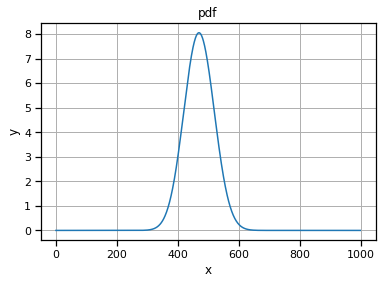

In [11]:
import numpy as np
from scipy import stats
# our events is a list of 0s and 1s, at fixed probabilities
flipcoin = np.random.choice(a= [0, 1],
                            p = [0.5, 0.5],
                            size=100)
print(flipcoin)
successes = flipcoin.sum()
failures = len(flipcoin) - successes

# prior parameters
alpha, beta = 1, 1

# calculate posterior distribution, using a beta distribution
posterior = stats.beta(alpha + successes, beta + failures)

# mean and 95% credible interval
mean = posterior.mean()
cr = posterior.interval(0.95)
print(cr)

#posterior distribution for plotting
xs = np.linspace(0, 1, num=1000)
pdf = posterior.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()

Here's a thousand times:

[1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1
 1 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0
 0 0 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 0 0 1
 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1
 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0
 0 0 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1
 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1
 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1
 0 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1
 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 0
 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1 1 0
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 1
 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1
 1 1 0 1 1 0 1 0 1 1 0 1 

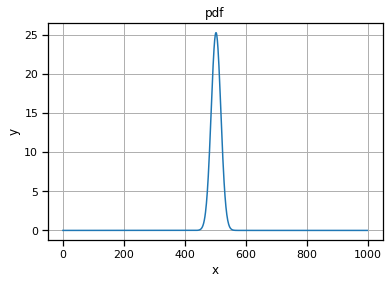

In [12]:
# our events is a list of 0s and 1s, at fixed probabilities
flipcoin = np.random.choice(a= [0, 1],
                            p = [0.5, 0.5],
                            size=1000)
print(flipcoin)
successes = flipcoin.sum()
failures = len(flipcoin) - successes

# prior parameters
alpha, beta = 1, 1

# calculate posterior distribution, using a beta distribution
posterior = stats.beta(alpha + successes, beta + failures)

# mean and 95% credible interval
mean = posterior.mean()
cr = posterior.interval(0.95)
print(cr)

#posterior distribution for plotting
xs = np.linspace(0, 1, num=1000)
pdf = posterior.pdf(xs)
plt.plot(pdf)
plt.xlabel('x')
plt.ylabel('y')
plt.title('pdf')
plt.grid(True)
plt.show()


Yup, that looks like the pdf that approximates the probabilities of coin tossing: It gets *tighter* and *tighter* the more data we have (the more flip coin events we record). 

This is the basic principle of Bayesian estimation: Update your posterior probability every time you recieve new data, sharpening your guess (i.e. reducing the error or standard deviation) of the mean value for the probability/ies.

<div style="text-align: right; color: gray">9</div>

# Flaws of frequentist statistics

**Frequentist Statistics** tests whether an event (hypothesis) ***occurs*** or ***not***. 

It calculates the probability of an event in the **long run** of the experiment (i.e the experiment is repeated under the same conditions to obtain the outcome). That probability *never changes*! It's what we computed with math formulae and python libraries.

Here above, a sampling distributions of fixed size is taken. Then what we have to do is to repeat the experiment an infinite number of times to see what distribution ***we converge to***. 

### What if
What if I perform an experiment with a stopping intention in mind that I will stop the experiment when it is repeated 1000 times, or I see minimum 300 heads in a coin toss. 

Now, what if person A chooses to stop tossing a coin when the total count reaches 100 while person B stops at 1000? For different sample sizes, we get ***different t-scores*** and ***different p-values***! Similarly, intention to stop may change from fixed number of flips to total duration of flipping. In this case too, we are bound to get different p-values.

This experiment presents us with a very common **flaw** of the frequentist approach, i.e. dependence of the result of an experiment on the number of times the experiment is repeated.

Frequentist statistics suffer other design and interpretation flaws:

- **p-values** measured against a sample (fixed size) statistic with some stopping intention changes with change in intention and sample size. i.e If two persons work on the same data and have different stopping intention, they may get two different  p- values for the same data, which is undesirable.

- **Confidence Intervals** (C.I), like p-values, depend heavily on the sample size. This makes the stopping potential absolutely absurd since no matter how many persons perform the tests on the same data, the results should be consistent.

- Confidence Intervals (C.I) are not **probability distributions** and therefore they ***do not*** provide the most probable value for a parameter and the most probable values.

- **p-values** are evaluated with an underlying modeling distribution (e.g. Student-T) *that may not be the correct analytic distribution to use*!

- **p-values** force you to imagine thousands of parallel universes with different outcomes reflecting all possibilities, proportional to probabilities, and then you the observer visit all these parallel universes and count outcomes to determine a p-value. I call this the *Professor marry Rihanna exploration*. So a p-value does not reflect the probability of something happening in our universe. Rather, it reflects the probability that our universe is one amonst all that you visited in your voyages. That is slightly confusing to me..

These reasons are *enough* to get you going thinking about the drawbacks of the frequentist approach. 

Read similar complaints from another [author](https://www.fharrell.com/post/pval-litany/) from somebody else, who underscores:

> The study must be capable of being repeated infinitely often, or one must play a mind game in which this is so.

Finally, read the [statement on p-values](https://www.amstat.org//asa/files/pdfs/P-ValueStatement.pdf) by the [American Statistical Association](https://en.wikipedia.org/wiki/American_Statistical_Association), founded in **Boston** in 1839. The ASA is the world’s largest community of statisticians and the oldest continuously operating professional science society in the United States. Its members serve in industry, government and academia in more than 90 countries, advancing research and promoting sound statistical practice to inform public policy and improve human welfare.

<div style="text-align: right; color: gray">10</div>

# A (surprising) Bayesian example

Bayesian thinking allows you to discover very strange results, which you wouldn't be able to otherwise. Here is an example.

Suppose, out of all the 4 championship races (F1) between Lewis Hamilton (Mercedes) and Charles Leclerc (Ferrari), Lewis won 3 times while Charles managed only 1.

So, if you were to bet on the winner of next race, who would he be ?

I bet you would say LH.

Now what if you are told that it rained **once** when Lewis won and **once** when Charles won and it is definite that it will rain on the next date. So, who would you bet your money on now, Mercedes or Ferrari?

By intuition, it is easy to see that chances of winning for Charles have increased drastically. By how much?

Suppose, B is the event of a Charles Leclerc win, and A is the event of raining. Therefore,

P(A) =1/2, since it rained twice out of four days.
P(B) is 1/4, since Charles won only one race out of four.
P(A|B)=1, since it rained every time when Charles won.

Substituting the values in the conditional probability formula:

$$p(B\;|\;A) = \frac{p(A\;|\;B) \; p(B)}{p(A)}$$

we get the probability to be 50%, which is ***almost the double of 25% when rain was not taken into account***!

This further strengthened our belief of Charles winning ***in the light of new evidence*** i.e **rain**. 

<div style="text-align: right; color: gray">11</div>

# Bayes Theorem

Bayes Theorem comes into effect when multiple events $A_i$ form an exhaustive set with another event $B$:

$B$, a union of probabilities conditional over a set of events $A_i$, can be written as:

$$B = \sum_{i=1}^n B \cap A_i$$

For example, you may think of $B$ as Mercedes winning the 2019 season trophy race given conditions $A_i$ (LH wins the point trophy, VB wins the points trophy, Ferrari wins but they cheated so they're DQed, etc.).

So, probability of B can be written as:

$$p(B) = \sum_{i=1}^n p(B \cap A_i)$$

By the law of probability **intersections** (assuming independence of events):

$$p(B \cap A_i) = p(B\;|\;A_i) \; p(A_i)$$

So, we get:

$$p(A_i\;|\;B) = \frac{p(B\;|\;A_i) \; p(A_i)}{\sum_{i=1}^n p(B \cap A_i)}$$

and finally:

$$p(A_i\;|\;B) = \frac{p(B\;|\;A_i) \; p(A_i)}{\sum_{i=1}^n p(B\;|\;A_i) \; p(A_i)}$$

***that*** is **Bayes' formula**!

<div style="text-align: right; color: gray">12</div>

# Bayesian hypothesis testing is superior to classical hypothesis testing

Models are the mathematical formulation of observed events. Parameters are the factors in the models affecting the observed data.

In tossing a coin, **fairness** of coin may be defined as the parameter denoted by $θ$. The outcome of the events may be denoted by $D$.

Answer this now: What is the probability of 4 heads out of 9 tosses ($D$) given the fairness of coin ($θ$). i.e $p(D|θ)$?

Let's talk about the *converse problem*: Given an outcome (D) what is the probability of the coin being fair ($p(θ)=0.5$)?

Let's represent it using Bayes Theorem:

$$p(θ\;|\;D)=\frac{p(D\;|\;θ) \; p(θ)}{p(D)}$$

Here, $p(θ)$ is the **prior** i.e the strength of our belief in the fairness of coin before the toss. It is perfectly okay to believe that the coin can have any degree of fairness between 0 and 1.

$p(D\;|\;θ)$ is the **likelihood** of observing our result given our distribution for θ. If we knew that coin was fair, this gives the probability of observing the number of heads in a particular number of flips.

$p(D)$ is the **evidence**. This is the probability of our data as determined by summing (or integrating) across all possible values of θ, ***weighted by how strongly we believe in those particular values of $θ$***.

If we had multiple views of what the fairness of the coin is (but didn’t know for sure), then this tells us the probability of seeing a certain sequence of flips for all possibilities of our belief in the coin’s fairness.

$p(θ\;|\;D)$ is the **posterior** belief of our parameters ***after observing the evidence*** i.e the number of heads.

To define our model correctly , we need **two** mathematical models beforehand. One to represent the likelihood function $p(D\;|\;θ)$, and the other for representing the distribution of prior beliefs. The product of these two gives the posterior belief $p(θ\;|\;D)$ distribution.

Since prior and posterior are both beliefs about the distribution of fairness of coin, intuition tells us that both should have the same mathematical form.

$p(y=1\;|\;θ)=$ If coin is fair $θ=0.5$, probability of observing heads (y=1) is 0.5.

$p(y=0\;|\;θ)=$ If coin is fair $θ=0.5$, probability of observing tails (y=0) is 0.5

We can combine the above mathematical definitions into a single definition to represent the probability of both outcomes. We already know about this kind of test. The model for coin tosses is the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). For a **single trial** however:

$$P(y\;|\;θ)= θ^y \; (1-θ)^{1-y}$$

This is called the [Bernoulli Likelihood Function](https://en.wikipedia.org/wiki/Bernoulli_distribution) and the task of flipping a coin *once* is called a [Bernoulli trial](https://en.wikipedia.org/wiki/Bernoulli_trial).

When we want to see a **series of heads or flips**, its probability is given by:

$$p(y_1, y_2, \cdots, y_n \; |\;θ) = \prod_{i=1}^n p(y_i \; |\;θ) = \prod_{i=1}^n θ^y \; (1-θ)^{1-y}$$

And we verify that the probability of number of heads $z$ turning up in $N$ number of flips ($y=1$ $z$ times for $n = N$, and $y=0$ $N-k$ times in the formula above) is the **binomial distribution**:

$$p(z, N \; |\;θ) =  θ^z \; (1-θ)^{N-z}$$

## The beta distribution

The mathematical function used to represent prior belief $p(\theta)$ ***with the most uninformative priors possible*** is known as the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). This is a ***new pdf for us***! It has some very nice mathematical properties which enable us to model beliefs about a binomial distribution. We'll study this distribution in more detail soon (it's widely used in baseball analytics).

If we use the probability density function (pdf) of the beta distribution for $p(\theta)$, it is of the form:

$$p(\theta) = \frac{x^{\alpha - 1}\;(1-x)^{\beta - 1}}{B(\alpha, \beta)}$$

$B$ is just to ensure that the total probability density function upon integration evaluates to 1. 

$α$ and $β$ are called the shape-deciding parameters of the density function. Here $α$ is analogous to number of heads in the trials and $β$ corresponds to the number of tails.

$α$ and $β$ are intuitive to understand since they can be calculated by knowing the mean ($μ$) and standard deviation ($σ$) of the distribution. They are related as so:

$$μ = \frac{\alpha}{\alpha + \beta}$$

$$σ = \sqrt{\frac{\alpha \; \beta}{(\alpha + \beta)^2\; (\alpha + \beta + 1)}}$$

When there is no toss (no observations yet), we believe that the coin is fair as depicted by the flat line in the first graph below.

When there are tosses (observations) and a bigger number of heads than tails, the graph shows a **peak** shifted towards the *right side*, indicating higher probability of heads, ***and that coin is not fair***.

As more tosses are observed, and tails come in to balance out the heads, the peak narrows and the mean value of the distribution shifts to the middle, increasing our confidence in the fairness of the coin.

</br >
<center>
<img src="ipynb.images/trials-heads.png" width=800 />
</center>

This experiment is entirely similar to the winning distribution of Lewis Hamilton. As the season gets underway, LH may be out of shape and he looses races, and his pdf is skewed towards the losing side, and maybe we don't believe in the power of the Hamilton anymore... But as the season stretches on, LH starts winning again, and his pdf starts shifting towards the winning side, past the mean value for any F1 racer.

Why did we pick a beta distribution for the prior $p(\theta)$? Because when we multiply it with a likelihood function, posterior distribution yields a form similar to the prior distribution, which is much easier to relate to and understand. So we kind of *cheated*, and it kind of worked out, didn't it? 

Now, let’s calculate **posterior belief** using Bayes theorem and the binomial distribution and beta distributions as depicted above:

$$p(θ\;|\;z, N) = \frac{p(z,N\;|\;θ) \; p(θ)}{p(z,N)}$$

$$p(θ\;|\;z, N) = \frac{θ^z \; (1-θ)^{N-z} \; θ^{\alpha - 1} \; (1-θ)^{\beta - 1}} {B(\alpha, \beta)\; p(z,N)}$$

$$p(θ\;|\;z, N) = p(θ\;|\;z + \alpha, N - x + \beta) $$

So, just knowing the mean $\mu$ and standard deviation $\sigma$ (and thus $\alpha$ and $\beta$) of our prior belief $p(θ)$ and by observing the number ($z$) of heads in $N$ flips, we can update our belief (that's our ***posterior***) about the model parameter $θ$. ***Analytically***! That is why the beta distribution is so popular in statistics.

Here's a data experiment: Suppose, you think that a coin is **biased**. It has a mean ($μ$) bias of around 0.6 with standard deviation of 0.1 (so it's not *fair*!).

Then from the formulas above,

$α$= 13.8 , $β$=9.2

and our distribution is biased on (*skewed towards*) the right side. 

Suppose now you observe 80 heads ($z=80$) in 100 flips($N=100$). We have our **before** and **after**, let’s compute our prior and posterior beliefs:

**prior** = $p(θ\;|\;α,β) = p(θ\;|\;13.8,9.2)$

**posterior** = $p(θ\;|\;z+α,N-z+β) = p(θ\;|\;93.8,29.2)$

As more and more flips are made and new data is observed, our beliefs get **updated**. 

>This is the real power of Bayesian Inference: Variable beliefs.

If you don't care about flipping coins, think about F1. As the F1 season gets  under way, LH may be in not-so-good shape and *loose* a few races before getting in shape and winning again. His pdf, at the end of the season, we know is skewed towards winning, but at the start of the season, that may not be the case. As the season progresses and new evidence comes in (LH wins), the LH pdf sharpens into the pdf we expect from LH from past seasons.

In a **frequentist** World view, data observed is considered random, but model parameters are considered **fixed**. How is that possible when our belief about the magic of the Hamilton changes depending on the number of his wins in the current F1 season? *Soooooooo wrong*! Our model parameters *cannot* be fixed! In a **Bayesian** World view, data is considered fixed and model parameters are treated as random variables with probability distributions. I *liiiiiiiiike that*!

### Frequentist statistics: p-value

In frequentist statistics, the **t-score** for a particular sample from a sampling distribution of fixed size is calculated. Then **p-values** are predicted. This interpretation suffers from the **flaw** that for sampling distributions of different sizes, one is bound to get different t-score and hence different p-value. So a p-value less than 5% does not guarantee that null hypothesis is **wrong** nor a p-value greater than 5% ensures that null hypothesis is **right**!!

### Frequentist statistics: Confidence Intervals

In frequentist statistics, **Confidence Intervals** suffer from the same defect. Moreover since C.I is not a probability distribution, there is no way to know which values are most probable.

### Bayesian statistics: Bayes factor

The [Bayes factor](https://en.wikipedia.org/wiki/Bayes_factor) is the equivalent of [p-value](https://en.wikipedia.org/wiki/P-value) in the Bayesian framework.

When $θ$ is the probability LH wins the F1 overall trophy for the season, the **null hypothesis** in a Bayesian framework assumes $∞$ probability distribution *only* at a particular value of a parameter (say $θ=0.5$) and a zero probability elsewhere. The **alternative hypothesis** is that ***all values of $θ$ are possible***, hence a **flat curve** representing the distribution. That's what we start with at the beginning of the F1 season: we have no idea if LH is going to win. It's 50-50.

As the season gets underway, Bayesian statistics adjust credibility (probability) of of $θ$ as we observe more data (F1 grand prix results). It can be seen that the probability distribution for LH is shifting towards the **alternative hypothesis** with a value higher than the **null hypothesis**. i.e. the alternative hypothesis is likely: We have higher and higher conviction that LH is going to win the season.

Bayes factor does not depend upon the actual distribution values of $θ$, but only the magnitude of the shift in values for each hypothesis.

In panel A below: left bar is the prior probability of the **null hypothesis** and the right bar the probability of the **alternative hypothesis**. Same as in panel B, but the bars have different shapes. F1 season starts and ***we don't know who's going to win*** (prior). As the season progresses, probability that LH wins gets higher and higher (posterior).

</br >
</br >
<center>
<img src="ipynb.images/prior-posterior.png" width=600 />
</center>

**Bayes factor** is defined as the ratio of the posterior odds to the prior odds:

$$BF = \frac{p(NH\;|\;z, N)}{p(AH\;|\;z, N)} = = \frac{p(NH)}{p(AH)}$$

Where $NH$ represents the **null hypothesis** and $AH$ the **alternative hypothesis**.

To reject a null hypothesis, a $BF < 0.1$ is *preferred*. The immediate benefits of using the **Bayes Factor** instead of **p-values** is that the BF is **independent of intentions and sample size**.

### Bayesian statistics: High Density interval (HDI)

The **High Density Interval** (HDI) is formed from the **posterior distribution** after observing new data (more F1 grand prix results). Since HDI is a probability, the 95% HDI gives the 95% most credible values. It is also guaranteed that 95 % values will lie in this interval, unlike the Confidence Interval.

Notice how the 95% HDI in prior distribution is wider than the 95% posterior distribution. This is because our belief in HDI increases upon observation of new data:

</br>
</br >
<center>
<img src="ipynb.images/hdi.png" width=400 />
</center>

Thanks to [Neeraj Singh](https://www.analyticsvidhya.com/blog/2016/06/bayesian-statistics-beginners-simple-english/) for a great introduction to the Bayes factor, reproduced (slightly improved) above.

<div style="text-align: right; color: gray">13</div>

# Experiment \#1: Horny Boston Sloths

Let's run an experiment ***using Bayesian estimation***, and a *simple* probabilistic library.

We want to compare the number of times Boston sloths become **romantic** after we introduce a new drug that is supposed to be a sloth [aphrodisiac](https://en.wikipedia.org/wiki/Aphrodisiac). Does it work?. We have a **before** and **after** distribution of how many times a week sloths engage in romantic acts. So we have a [bivariate](https://en.wikipedia.org/wiki/Function_(mathematics)#Multivariate_function) data experiment (`before` and `after` parameters). 


</br >
<center>
<img src="ipynb.images/slothskissing.jpg" width=400 />
    I love you!
</center>

Instead of using classical frequentist statistical estimation theory, we'll use a **Bayesian model**. That means that instead of finding model parameters as **point estimates**, we'll identify model parameters as **pdfs**.

>**NOTE**: In frequentist estimation (MOM, MLE), our model parameters are **point estimates**. In Bayesian estimation, our model parameters are **probability density functions** (pdfs)!

Consider an indexed collection of random variables $y_{1},\ldots ,y_{n}$. The joint probability distribution for $y_1, y_2, \ldots$ is a probability distribution that gives the probability that each of $y_1, y_2, \ldots$ falls in any particular range or discrete set of values specified for that variable. In the case of only two random variables, this is called a bivariate distribution, but the concept generalizes to any number of random variables, giving a multivariate distribution. Applying the chain rule and Bayes' theorem yields:

$$p(\theta \; | \; (y_i)_{i=1}^n) = \prod_{i = 1}^n p(y_i \; | \; \theta) . p(\theta)$$

So multivariate distributions in Bayes' estimation is piece of cake... Just **products** of univariate distributions (assuming independent random variables). So, let's simpligy and pick a univariate distribution: a **single** random variable $R$ (romance).

Let's build a Bayesian model using a [**Poisson**](https://en.wikipedia.org/wiki/Poisson_distribution) likelihood with **exponential** priors for $\lambda_1$ and $\lambda_2$. 

Ok, what does *that* mean, professor? 

That means we assume sloth acts of romance ($R$) per week are bunched up around a certain statistic, per Poisson, before ($\lambda_1$) and another statistic after ($\lambda_2$), and we are going to traverse $\lambda$ state space ***exponentially*** to try to locate the best $\lambda$s (the best parameters for our *before* and *after* Poissons). 

Let's recap: 
- Our model is a **Poisson** pdf
- The model parameter is $\lambda$
- We have two models (thus two parameters): before aphrodisiac, and after
- We want to find the optimal values of the parameters
- Since we're dealing with Bayesian statistics, we'll model these two parameters as pdfs
- Our walks through state space to find solutions for the parameters will be exponential (not in speed, but in trajectory). 

By Bayes' law:

$$
p(\lambda_1, \lambda_2 \mid R) \;\propto p( R \mid \lambda_1, \lambda_2)\, p(\lambda_1)\, p(\lambda_2) \;\;\; \text{(no denominator!)}\\
p( R \mid \lambda_1, \lambda_2) \;\sim \mathrm{Poisson}(R\mid\lambda_1)\,\mathrm{Poisson}(R\mid\lambda_2) \\
p(\lambda_1) \;\sim \mathrm{Exp}(\lambda) \\
p(\lambda_2) \;\sim \mathrm{Exp}(\lambda) 
$$

This analysis method we'll follow is known as `Bayesian estimation` using probabilistic programming. 

We have the equations above,and we want to know *likely* values for $\lambda_1$ and $\lambda_2$. This information is contained in the posterior distribution $p(\lambda_1, \lambda_2 \mid R)$. To infer values for $\lambda_1$ and $\lambda_2$, we sample from the posterior using MCMC samplers. Let's use the [Metropolis](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm. No math! *Programming*, instead!

## Sampyl

`PyMC3` is not the only MCMC package. `Sampyl` is another, simpler one. [Read](https://pypi.org/project/sampyl-mcmc/) about it. [Here](http://matatat.org/sampyl/introduction.html) too. Let's use that one since some of you still have trouble installing `PyMc3`. Better use an Anaconda terminal. 
```(python)
pip install sampyl-mcmc
```

If that does not work, try the below.

In [13]:
# !pip install sampyl-mcmc

So, where's our data? We *don't have data* for romantic adventures of Boston sloths! Oh no!

</br >
<center>
<img src="ipynb.images/home-alone.jpg" width=300 />
</center>

So, we ***make up the data*** using two Poisson distributions, one with parameter 7 (before aphrodisiac), the other with parameter 9 (after aphrodisiac). 

>So, we're cheating! Obviously, that means that the population statistics before and after inoculation with the aphrodisiac are ***different***. So the aphrodisiac is *working*! But let's *assume* we do not know where the data came from.

(yes, professor can do that, ***you cannot*** :-)

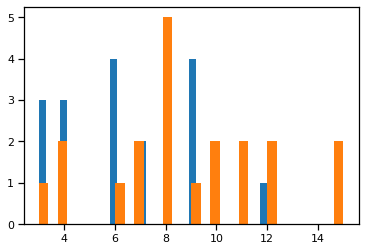

In [17]:
# Fake data for the day before and after aphrodisiac introduction into Boston sloth population
# Let's be conservative and assume that the aphrodisiac will increase acts of romance by 2 per week. Let's record data weekly.
before = np.random.poisson(7, size=20)
after = np.random.poisson(9, size=20)
plt.hist(before, bins=32)
plt.hist(after, bins=32)

# Define the log-P function here
def logp(λ1, λ2):
    model = smp.Model()
    # Poisson log-likelihoods
    model.add(smp.poisson(before, rate=λ1),
              smp.poisson(after, rate=λ2))

    # Exponential log-priors for rate parameters
    model.add(smp.exponential(λ1),
              smp.exponential(λ2))
    
    return model()

Let's MCMC-simulate with `Sampyl`. We seed our starting condition with point estimates from the classical method called **M**aximum **A** **P**osteriori estimation (MAP). We skipped [this](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation), but it's pretty similar to MLE. And `Sampyl` has an API for evaluating it, called `find_MAP()`.

Then we say simulate for 10,000 timesteps and throw away the first 2,000 timesteps. Then give us statistical results of our simulation.

In [21]:
import sampyl as smp
from sampyl import np
    
start  =  smp.find_MAP(logp, {'λ1':1., 'λ2':1.})
sampler = smp.Metropolis(sloths, start)
chain = sampler(100000, burn=20000, thin=4)

ImportError: cannot import name 'np' from 'sampyl.core' (/opt/anaconda3/lib/python3.7/site-packages/sampyl/core/__init__.py)

In [22]:
print(sampler.var_names)

NameError: name 'sampler' is not defined

These are the **values** of the two $\lambda$s we simulated (the *values*, not the *pdf$s for each):

In [23]:
plt.plot(chain.λ1)
plt.plot(chain.λ2)

NameError: name 'chain' is not defined

Now to see if there is a significant difference between **before aphrodisiac** and **after aphrodisiac**, we can look for the **difference** $\delta =  \lambda_2 - \lambda_1$, then find the probability that $\delta > 0$. Now let's find the pdf for $\delta$ by plotting the histogram of the difference between the simulated values of $\lambda_1$ and $\lambda_2$, and let's also plot a vertical line at $\delta = 2$ because we ***know that the difference between the two $\lambda$s should be 2***!

In [25]:
delta  = chain.λ2  - chain.λ1
_ =  plt.hist(delta, bins=30)
_ =  plt.vlines(2,  0,  250,  linestyle = '--')

NameError: name 'chain' is not defined

In [26]:
delta

array([[1.50000000e-01, 1.05000000e-02, 3.60000000e-03, 7.56000000e-04,
        1.05840000e-04, 2.22264000e-05, 6.22339200e-06, 1.30691232e-06,
        1.82967725e-07, 1.28077407e-08, 4.39122540e-09, 6.14771555e-10,
        1.29102027e-10, 3.61485675e-11, 2.53039972e-12, 6.50674214e-13,
        9.10943900e-14, 2.55064292e-14, 7.14180017e-15, 4.99926012e-16],
       [5.00000000e-02, 2.25000000e-02, 2.70000000e-03, 1.62000000e-04,
        4.53600000e-05, 3.17520000e-06, 1.33358400e-06, 1.86701760e-07,
        7.84147392e-08, 2.74451587e-08, 3.29341905e-09, 3.95210286e-10,
        2.37126171e-11, 7.74612160e-12, 5.42228512e-12, 3.25337107e-13,
        3.90404528e-14, 5.46566340e-15, 1.53038575e-15, 1.07127003e-15]])

Pretty close, huh?! 

Let's compute the probability that acts of romance **increased**: the difference between the means of before and after, and our confidence interval.

In [ ]:
p  =  np.mean(delta  >  0)
effect  =  np.mean(delta)
CR  =  np.percentile(delta, (2.5, 97.5))
print("{:.3f} probability the rate of acts of romance increased".format(p))
print("delta = {:.3f}, 95% CR = {{{:.3f} {:.3f}}}".format(effect, *CR))

Wow, we are ***sure*** the acts of romance increased!

And what's the size of the difference? About 2.5 for a 95% confidence interval, where the true value lies in the interval [1.17, 4].

The true difference in rates was two per hour, marked with the dashed line. We got it right!

Our posterior is showing an effect, and our best estimate is that the rate increased by about 2.5 acts of romance per week. The 95% credible region is [1.663 2.327] which idicates that there is a 95% probability that the true effect lies with the region, as it does.

### NUTS

Now, let's use the [NUTS](https://en.wikipedia.org/wiki/Stan_(software)#Algorithms) algorithm to sample from the posterior. We were told it's a cleverer (does that word exist?) algorithm..

In [ ]:
nuts = smp.NUTS(logp, start)
chain = nuts.sample(2100, burn=100)
_ = plt.plot(chain.λ1)
_ = plt.plot(chain.λ2)

In [ ]:
delta = chain.λ2 - chain.λ1
_ = plt.hist(delta, bins=30)
_ = plt.vlines(2, 0, 250, linestyle='--')
p = np.mean(delta > 0)
effect = np.mean(delta)
CR = np.percentile(delta, (2.5, 97.5))
print("{:.3f} probability the rate of weekly romantic acts increased".format(p))
print("delta = {:.3f}, 95% CR = {{{:.3f} {:.3f}}}".format(effect, *CR))

Exactly the same! I specified no random seed, so running it multiple times should generate different results, but the net effect and conclusion should be the same.

Bayesian estimation rocks! A bit complicated to understand what it means to use a model that is a pdf with parameters that ***are themselves pdfs***, but eventually I am sure you will understand it's just a more mathemtically correct way to give you an estimate of your model parameters because ***it also gives you an estimate of the amount of error*** you might be making in your modeling.

No crazy T-test or voodoo math!

## Conclusion

What's the **model type** for the data you observe? That's the ***art*** of the statistician. You need to pick the right one. It's the same in Machine Learning (ML): You need to pick the right model (CNN, RNN, LSTM, etc.).

What are the **parameters** of your model? That's the ***science*** of the statistician. That's what I'm trying to *teach you*. The art only comes with **experience**!

In **classical statistical estimation**, the parameters are **point estimates**, and if you want an error range, you need to do voodoo math like the **T-test**. 

In **Bayesian statistical estimation**, the parameters are ***pdf***s and thus naturally yield the probable value (the mean of the pdf), ***and its error*** (the standard deviation of the pdf)!

<div style="text-align: right; color: gray">14</div>

# Experiment \#2: *Bayesian classification* with HMMs

>*Our HMM experiment that used the Viterbi algorithm was fun. But, professor, the python was a little bit complicated. Can we simplify if we use a canned package*?

Why, I'm glad you asked! Yes we can!
```(python)
pip install pomegranate
```

We all enjoy tossing coins, right? You'd be amazed what you can buy on Amazon today. Some people are known to use rigged coins! Can we unmask them just from observations? In other words, our hidden states will be about cheaters. Our observations will be a succession of `heads` or `tails`.

Let's make it even more complicated: Players fall into 3 categories, `honest`, `smart cheaters`, and `dumb cheaters`. Honest (non-cheaters) do not use rigged coins. Smart cheaters switch between rigged and unrigged coins in order to deceive us. Dumb cheaters only use rigged coins.

In [ ]:
import pomegranate as pm
import numpy as np

Let's start by creating our HMM's. Since this is a simple example, we will only have 2 states, `rigged` and `unrigged`, with discrete distributions.

In [ ]:
rigged = pm.State(pm.DiscreteDistribution({'H': 0.8, 'T': 0.2}), name="rigged")
unrigged = pm.State(pm.DiscreteDistribution({'H': 0.5, 'T': 0.5}), name="unrigged")

Now let's create our non-cheater and dumb cheater since their HMMs consist of a single state.

In [ ]:
non_cheater = pm.HiddenMarkovModel(name="non-cheater")
non_cheater.add_state(unrigged)

dumb_cheater = pm.HiddenMarkovModel(name="dumb-cheater")
dumb_cheater.add_state(rigged)

Add our starting states to our models:

In [ ]:
non_cheater.start = unrigged
dumb_cheater.start = rigged

Add transitions for our non-cheater and dumb cheater, These are the only possibilities:

In [ ]:
non_cheater.add_transition(unrigged, unrigged, 1)
dumb_cheater.add_transition(rigged, rigged, 1)

We ***bake*** our models to finalize the HMM structure: 

<br />
<center>
<img src="ipynb.images/cookies-in-the-oven.jpg" width=400 />
</center>

>**NOTE**: Here, *baking* is the same thing as *compiling*, something we always do to prepare the probabilistic sructures that will allow us to do our Machine Learning. This is the same thing as compiling a program from english code to machine code, or from english code to bytecode. 

In [ ]:
non_cheater.bake()
dumb_cheater.bake()

Now let's create our smart cheater.

In [ ]:
smart_cheater = pm.HiddenMarkovModel(name="smart-cheater")

Smart cheaters *start out* half the time with an unrigged coin, half the time without:

In [ ]:
smart_cheater.add_transition(smart_cheater.start, unrigged, 0.5)
smart_cheater.add_transition(smart_cheater.start, rigged, 0.5)

Add our transition matrix:

In [ ]:
smart_cheater.add_transition(rigged, rigged, 0.5)
smart_cheater.add_transition(rigged, unrigged, 0.5)
smart_cheater.add_transition(unrigged, rigged, 0.5)
smart_cheater.add_transition(unrigged, unrigged, 0.5)

Now, *bake* our smart cheater:

In [ ]:
smart_cheater.bake()

Let's view the structure of our HMM:

In [ ]:
non_cheater.plot()

In [ ]:
dumb_cheater.plot()

In [ ]:
smart_cheater.plot()

Let's create a Naive Bayes classifier:

In [ ]:
players = pm.BayesClassifier([non_cheater, smart_cheater, dumb_cheater])

Let's create a sequence of coin tosses to test our classifier on:

In [ ]:
data = np.array([list('HHHHHTHTHTTTTHHHTHHTTHHHHHTH'),
                 list('HHHHHHHTHHHHTTHHHHHHHTTHHHHH'),
                 list('THTHTHTHTHTHTTHHTHHHHTTHHHTT')])

Check the log probability of each string of data occurring under each model:

In [ ]:
probs = players.predict_proba(data)

for i in range(len(probs)):
    print("For sequence {}, {:.3}% non-cheater, {:.3}% smart cheater, {:.3}% dumb cheater."
          .format(i+1, 100*probs[i][0], 100*probs[i][1], 100*probs[i][2]))

Classify whether a non-cheater (0), smart cheater (1), or dumb cheater (2) created the string of coin tosses:

In [ ]:
output = players.predict(data)

for i in range(len(output)):
    print("Sequence {} is a {}".format(i+1, "non-cheater" if output[i] == 0 else 
                                       "smart cheater" if output[i] == 1 else 
                                       "dumb cheater"))

You can also train the HMM through Naive Bayes. Let's used the following data ***labelled*** as known games from smart cheaters:

In [ ]:
X = np.array([list('HHHHHTHTHTTTTH'),
              list('HHTHHTTHHHHHTH')])

y = np.array([1, 1])

Fit our Bayes classifier to our data (just like we do with random forests in `sklearn`!):

In [ ]:
players.fit(X, y)

Now predict the hidden state (player) of the following sequence: 

In [ ]:
players.predict(np.array([list('HHHHHTHTHTTTTH')]))

<div style="text-align: right; color: gray">15</div>

# Conclusion

Bayes' formula revolutionized the way we do statistics today. The reason Neandertal data scientists could not leverage Bayes formula was because it wwas difficult to compute the denominator without powerful laptops. Now we can, and we have cool libraries that can do that for us!

Next lectures, we'll take a closer look at that famous `Metropolis` algorithm to understand how it works, review Bayesian hypothesis testing, and move on to the more advanced `PyMc3` library for probabilistic programming. So please install it!

The key take aways from this lecture are:

- How probabilities aren't *fixed*, as with frequentist statistics. Instead, Bayes' formula is used to update beliefs so that a **prior belief** (probability) gives way to a refined **posterior belief** (probability)

- How Bayesian model parameters are not **point estimates** anymore, but entire **pdfs** of their own

- How to statistically compare two datasets without having to think up null experiments, p-values, and will-Rihanna-marry-professor models. Just pick the ***model for the data*** and the ***model for each model parameter***, run the Metropolis algorithm, get the distribution of each parameter, deduce mean parameter values and parameter errors, and conclude

- Two very neat libraries for probabilistic programming: `sampyl` and `pomegranate`.